In [150]:
%matplotlib inline
import numpy as np
from pylab import *
from astropy.io import fits
from statsmodels.robust import scale
from sklearn import preprocessing as pp
from time import time

from seaborn import *
import statsmodels.api as sm
from sklearn.neighbors import KernelDensity

style.use('fivethirtyeight')
from IPython import display
rcParams['axes.grid'] = False
rcParams['lines.linewidth'] = 1.0

In [2]:
from ipywidgets import widgets
# from IPython.display import display
from IPython         import display

In [3]:
mask0   = fits.open('NRCNRCALONG-DARK-53421914341_1_485_SE_2015-12-08T21h45m34_mask.fits')
darks0  = fits.open('NRCNRCALONG-DARK-53421914341_1_485_SE_2015-12-08T21h45m34.fits')

In [4]:
nQuirks = sum(mask0[0].data[0] != 0)
nQuirks

5042

In [5]:
mask    = mask0[0].data[0]
darks   = darks0[0].data

In [172]:
flags_loc = transpose(np.where(mask != 0))
flags_loc

array([[   0, 1282],
       [   1, 1018],
       [   4,  378],
       ..., 
       [2043,  412],
       [2043,  530],
       [2043,  803]])

In [130]:
quirks_store  = np.loadtxt('quirks_FINAL_for_cnaw_mask_CV3_dark_frames.txt')
classes_store = np.loadtxt('myclasses_new_FINAL_for_cnaw_mask_CV3_dark_frames.txt').astype(int)

Check If All Class 1 Bad Pixels Are Indeed Just Noisy Pixels
---

In [8]:
quirks_store[classes_store == 1].shape

(141, 108)

In [ ]:
fig = figure()#figsize=(6,6))
ax  = fig.add_subplot(111)
# ax.plot([nan,nan])
corrections = []
for cnow in np.where(classes_store == 1)[0]:
    # ax.lines.pop()
    ax.clear()
    ax.plot(quirks_store[cnow] - median(quirks_store[cnow]))
    ax.set_title('Entry:' + str(cnow) + '/ Class:' + str(classes_store[cnow]))
    fig.canvas.draw()
    display.display(plt.gcf())
    display.clear_output(wait=True)
#     checkClass = input('Is this a Noisy Pixel? ');
#     if checkClass != '':
#         corrections.append([cnow, checkClass])
# for cnow in np.where(classes_store == 1)[0]:
#     plt.plot(quirks_store[cnow])
#     display.clear_output(wait=True)
#     display.display(plt.gcf())
#     checkClass = input('Is this a Noisy Pixel? ');print(checkClass)
#     plt.clf()
#     display.clear_output(wait=True)

Check If All Class 4 Bad Pixels Are Indeed Just CR Pixels
---

In [10]:
quirks_store[classes_store == 4].shape

(703, 108)

In [11]:
np.where(classes_store == 6)[0]

array([  44,  196,  223,  307,  386,  406,  413,  466,  845,  909, 1002,
       1118, 1168, 1256, 1315, 1581, 1812, 2090, 2109, 2131, 2191, 2206,
       2246, 2360, 2459, 2524, 2533, 2584, 2639, 2676, 2725, 2882, 2887,
       2931, 2932, 2936, 2948, 2991, 2996, 3036, 3045, 3052, 3064, 3147,
       3350, 3440, 3474, 3559, 3696, 3836, 3914, 3951, 4077, 4103, 4293,
       4294, 4298, 4334, 4435, 4448, 4466, 4745, 4834, 4866, 5040])

/Users/jonathanfraine/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


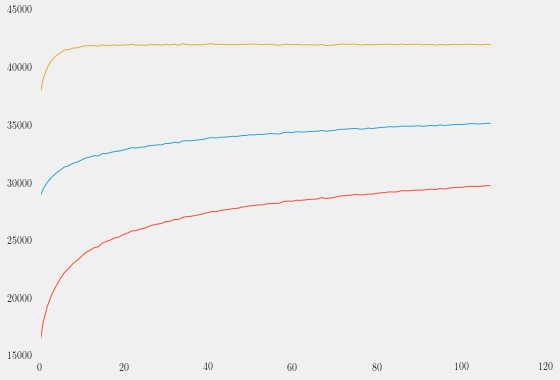

In [12]:
plot(quirks_store[140]);
plot(quirks_store[260]);
plot(quirks_store[380]);

In [13]:
((quirks_store.T - np.min(quirks_store,axis=1)) / (np.max(quirks_store,axis=1) - np.min(quirks_store, axis=1))).shape

(108, 5042)

In [14]:
((quirks_store.T - np.min(quirks_store,axis=1)) / (np.max(quirks_store,axis=1) - np.min(quirks_store, axis=1))).T[classes_store == 4].T.shape

(108, 703)

In [15]:
np.sum(classes_store == 2) // 100

36

In [16]:
quirk_store_norm = ((quirks_store.T - np.min(quirks_store,axis=1)) / (np.max(quirks_store,axis=1) - np.min(quirks_store, axis=1))).T

In [17]:
classNow  = 4
k = 1
stepsize  = 100
quirksNow = quirk_store_norm[classes_store == classNow][k*stepsize:(k+1)*stepsize].T
quirksNow.shape

(108, 100)

In [131]:
classes_store_bak = np.copy(classes_store)

/Users/jonathanfraine/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


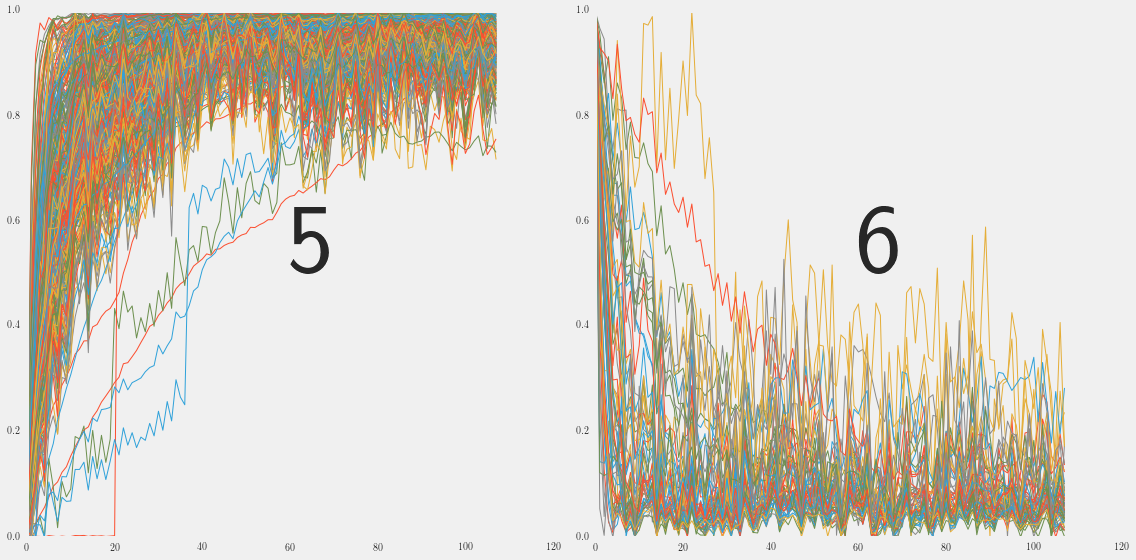

In [132]:
fig = figure(figsize=(16,8))
ax1  = fig.add_subplot(121)
ax2  = fig.add_subplot(122)
ax1.plot(quirk_store_norm[classes_store == 5].T, lw=1);
ylims = ax1.get_ylim()
xlims = ax1.get_xlim()
xyNow = [np.min(xlims) + 0.5*diff(xlims),
         np.min(ylims) + 0.5*diff(ylims)]
ax1.annotate(str(5), xyNow, fontsize=75)
ax2.plot(quirk_store_norm[classes_store == 6].T, lw=1);
ylims = ax2.get_ylim()
xlims = ax2.get_xlim()
xyNow = [np.min(xlims) + 0.5*diff(xlims),
         np.min(ylims) + 0.5*diff(ylims)]
ax2.annotate(str(6), xyNow, fontsize=75)


In [20]:
darks.shape

(108, 2048, 2048)

In [21]:
darks_trnspsd = np.transpose(darks, axes=(1,2,0))

/Users/jonathanfraine/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


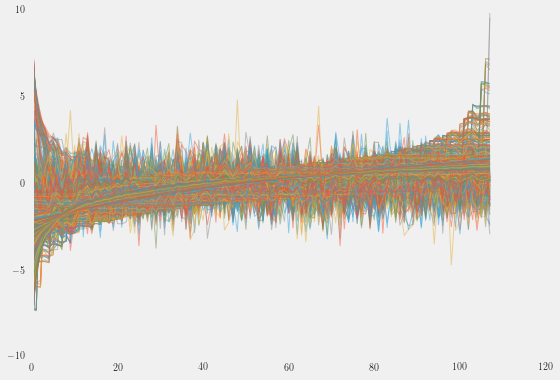

In [22]:
for irow in range(len(quirks_store)):
    quirk_pp  = pp.scale(quirks_store[irow])
    # print(std(quirk_pp), scale.mad(quirk_pp))
    plot(quirk_pp, alpha=0.5)# - median(darks_trnspsd[icol,irow])))
# darks_scaled  = pp.scale(darks,axis=0)

In [23]:
darks.shape, darks_trnspsd.shape

((108, 2048, 2048), (2048, 2048, 108))

In [24]:
darks_reshaped = darks_trnspsd.reshape(darks_trnspsd.shape[0]*darks_trnspsd.shape[1], darks_trnspsd.shape[2])

In [25]:
darks_reshaped.shape

(4194304, 108)

In [26]:
icol,irow = np.random.randint(0,2048,2)
pp.scale(darks_trnspsd[icol,irow] / median(darks_trnspsd[icol,irow]))

array([-1.65555083, -0.48309516, -0.1437001 , -0.42138697, -1.13103119,
       -1.069323  ,  0.47338183, -1.62469674, -0.32882468, -1.50128035,
       -0.1437001 ,  1.89267028,  0.7510687 ,  0.90533919, -2.24177867,
        1.27558835, -0.79163613, -0.23626239,  0.19569496, -1.50128035,
       -0.48309516, -0.26711648,  1.36815064, -1.56298854, -0.42138697,
       -1.71725903, -0.02028371,  0.41167364, -0.17455419, -1.65555083,
       -0.17455419, -1.069323  ,  0.93619328, -2.42690325,  1.83096209,
        1.02875557, -0.48309516, -0.32882468,  0.16484087,  0.31911135,
        1.49156702,  2.10864896,  0.04142448,  1.18302606,  0.47338183,
        0.47338183,  0.68936051, -0.48309516,  0.72021461,  0.25740316,
        1.52242112,  0.59679822,  0.90533919, -0.69907384,  0.96704738,
        0.65850641, -1.22359348, -1.87152951,  1.49156702,  1.33729654,
       -0.20540829,  0.56594412, -0.1437001 , -0.76078203,  0.19569496,
       -0.45224106, -1.0384689 ,  0.53509003, -1.84067541, -1.80

In [27]:
darks_norm  = darks / median(darks, axis=0)

In [28]:
darks_std   = std(darks_norm, axis=0)
darks_std.shape

(2048, 2048)

In [29]:
darks_med_std = median(darks_std)

In [30]:
darks_flat = []
for irow in range(darks_reshaped.shape[0]):
    limit_check = std(darks_reshaped[irow] / median(darks_reshaped[irow])-1) < 2*darks_med_std
    # print(limit_check, std(darks_reshaped[irow] / median(darks_reshaped[irow])), darks_med_std)
    if limit_check:
        darks_flat.append(darks_reshaped[irow])

nNormals    = len(darks_flat)
nNormals

4188264

In [31]:
darks_flat = np.array(darks_flat)
darks_flat.shape

(4188264, 108)

In [32]:
darks_norm_trnspsd = np.transpose(darks_norm, axes=(1,2,0))
darks_norm_flat    = darks_norm_trnspsd[darks_std < 2*darks_med_std]

In [33]:
darks_norm_flat.shape

(4188264, 108)

In [34]:
darks_norm_flat.shape[0]

4188264

Simulate RTNs because the CV3 training data has None
---

/Users/jonathanfraine/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


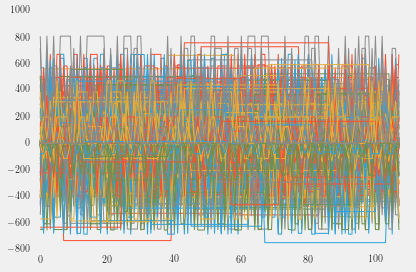

In [1129]:
np.random.seed(42)
saturation  = 2**16
dynRange    = 2**8
nSamps      = 1000
nSig        = 4.0
nFrames     = darks_norm_flat.shape[1]
rtn_syn     = np.zeros((nSamps, nFrames))
rtn_loc     = np.zeros((nSamps))
rtn_classes = np.zeros(nSamps)
maxRTNs     = np.int(0.9*nFrames)
maxWidth    = 50
minWidth    = 10
rtnCnt      = 0

dark_inds = np.arange(darks_norm_flat.shape[0])
frame_inds= np.arange(darks_norm_flat.shape[1])
for irow in np.random.choice(dark_inds,nSamps,replace=False):
    rtn_syn[rtnCnt] = np.copy(darks_norm_flat[irow])
    if darks_norm_flat[irow].std() > 50:
        print(darks_norm_flat[irow].std())
    nRTNs     = np.random.randint(maxRTNs)
    rtn_loc[rtnCnt] = irow
    coinflip  = np.random.randint(0, 2)
    sign_rand = np.random.choice([-1,1])
    minJump   = nSig*std(rtn_syn[rtnCnt] - median(rtn_syn[rtnCnt]))
    jump      = abs(np.random.normal(0,dynRange)) + minJump
    if coinflip:
        rtn_classes[rtnCnt] = 0
        RTN_locs  = np.random.choice(frame_inds, nRTNs, replace=False)
        for iRTN in RTN_locs:
            rtn_syn[rtnCnt][iRTN] += sign_rand*jump
    else:
        randWidth = np.random.randint(minWidth, maxWidth + 1)
        randStart = np.random.randint(0, nFrames - randWidth + 1)
        rtn_syn[rtnCnt][randStart:randStart+randWidth] += sign_rand*jump
        rtn_classes[rtnCnt] = 1
    
    rtn_syn[rtnCnt][rtn_syn[rtnCnt] > saturation] = saturation
    # if not rtnCnt % 100:
    plot(rtn_syn[rtnCnt] - median(rtn_syn[rtnCnt]))
    
    rtnCnt  = rtnCnt + 1

xlim(-1,110);
# ylim(-100,100);

In [36]:
darks_flat_med_axis0 = np.median(darks_flat,axis=0)
darks_flat_med_axis1 = np.median(darks_flat,axis=1)

In [37]:
darks_flat_std_axis0 = np.std(darks_flat,axis=0)
darks_flat_std_axis1 = np.std(darks_flat,axis=1)

In [38]:
darks_flat_med_axis0_norm = darks_flat_med_axis0[1:] / median(darks_flat_med_axis0[1:])

In [144]:
classLabels = {1:'Noisy', 2:'HP', 3:'IHP', 4:'LHP', 5:'SHP', 6:'CR', 7:'RTN0', 8:'RTN1'}
for k in range(1,9):
    print(k, classLabels[k])

1 Noisy
2 HP
3 IHP
4 LHP
5 SHP
6 CR
7 RTN0
8 RTN1


In [151]:
def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scikit-learn"""
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)

In [400]:
flags_loc[:,0]

array([   0,    1,    4, ..., 2043, 2043, 2043])

/Users/jonathanfraine/anaconda/lib/python3.5/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)
/Users/jonathanfraine/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/Users/jonathanfraine/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


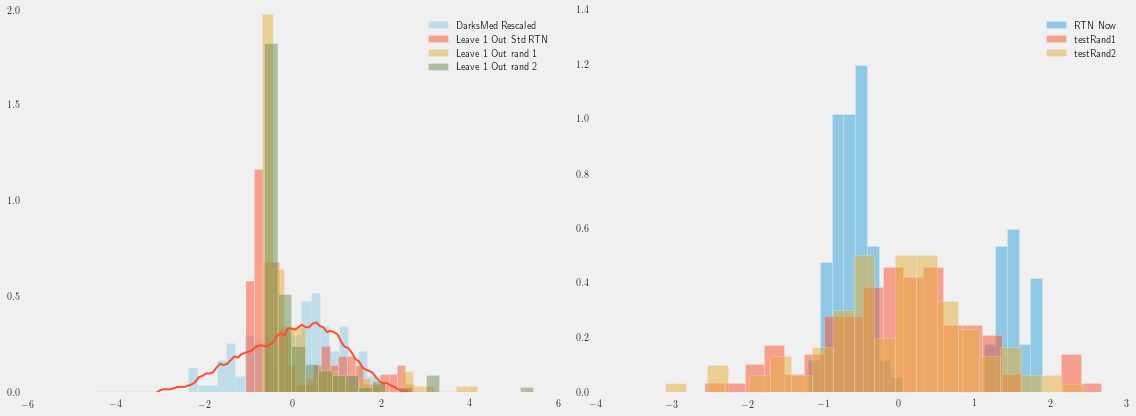

In [704]:
# x0, y0    = flags_loc[2187]

fig = figure(figsize=(16,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.clear()

rtnNow = 3

leave1out = np.zeros(rtn_syn[rtnNow].size)
for k in range(rtn_syn[rtnNow].size):
    leave1out[k] = np.std(hstack([rtn_syn[rtnNow][:k],rtn_syn[rtnNow][k+1:]]))


testRand1 = np.random.normal(rtn_syn[rtnNow].mean(), 0.1*rtn_syn[rtnNow].std(), rtn_syn[rtnNow].size)
testRand2 = np.random.normal(rtn_syn[rtnNow].mean(), rtn_syn[rtnNow].std(), rtn_syn[rtnNow].size)

leave1out1 = np.zeros(rtn_syn[rtnNow].size)
leave1out2 = np.zeros(rtn_syn[rtnNow].size)
for k in range(rtn_syn[rtnNow].size):
    leave1out1[k] = np.std(hstack([testRand1[:k],testRand1[k+1:]]))
    leave1out2[k] = np.std(hstack([testRand2[:k],testRand2[k+1:]]))

l1o_diffRTN = np.std(rtn_syn[rtnNow]) - leave1out
l1o_diffTR1 = np.std(testRand1) - leave1out1
l1o_diffTR2 = np.std(testRand2) - leave1out2

ax1.hist(pp.scale(darks_flat_med_axis0), bins=20, normed=True, alpha=0.25, label='DarksMed Rescaled')
kde2 = sm.nonparametric.KDEUnivariate(pp.scale(darks_flat_med_axis0))
kde2.fit(kernel='uni', fft=False)
ax1.plot(kde2.support, kde2.density, lw=2, color=rcParams['axes.color_cycle'][1])
ax1.hist((l1o_diffRTN - l1o_diffRTN.mean()) / l1o_diffRTN.std(), bins=20, label='Leave 1 Out Std RTN', normed=True,alpha=0.5);
ax1.hist((l1o_diffTR1 - l1o_diffTR1.mean()) / l1o_diffTR1.std(), bins=20, label='Leave 1 Out rand 1', normed=True,alpha=0.5);
ax1.hist((l1o_diffTR2 - l1o_diffTR2.mean()) / l1o_diffTR2.std(), bins=20, label='Leave 1 Out rand 2', normed=True,alpha=0.5);

ax2.hist((rtn_syn[rtnNow] - rtn_syn[rtnNow].mean()) / rtn_syn[rtnNow].std(), bins=20, label='RTN Now', normed=True,alpha=0.5);
ax2.hist((testRand1 - testRand1.mean()) / testRand1.std(), bins=20, label='testRand1', normed=True,alpha=0.5);
ax2.hist((testRand2 - testRand2.mean()) / testRand2.std() , bins=20, label='testRand2', normed=True,alpha=0.5);
ax1.legend(loc=0)
ax2.legend(loc=0)
fig.canvas.draw()
# display.display(plt.gcf())
# display.clear_output(wait=True)

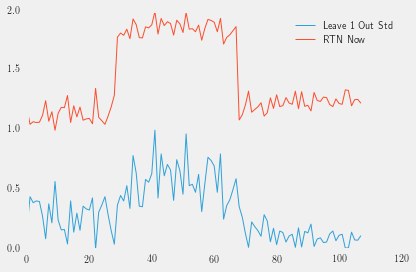

In [642]:
# x0, y0    = flags_loc[2187]

fig = figure()
ax  = fig.add_subplot(111)
rtnNow = 1
for rtnNow in range(len(rtn_syn)):
    ax.clear()
    leave1out = np.zeros(rtn_syn[rtnNow].size)
    for k in range(rtn_syn[rtnNow].size):
        leave1out[k] = np.std(hstack([rtn_syn[rtnNow][:k],rtn_syn[rtnNow][k+1:]]))
    
    ax.plot(rescale(np.std(rtn_syn[rtnNow]) - leave1out), label='Leave 1 Out Std');
    ax.plot(rescale(rtn_syn[rtnNow])+1, label='RTN Now');
    ax.legend(loc=0)
    fig.canvas.draw()
    display.display(plt.gcf())
    display.clear_output(wait=True)

1115 1133


(-1, 110)

/Users/jonathanfraine/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


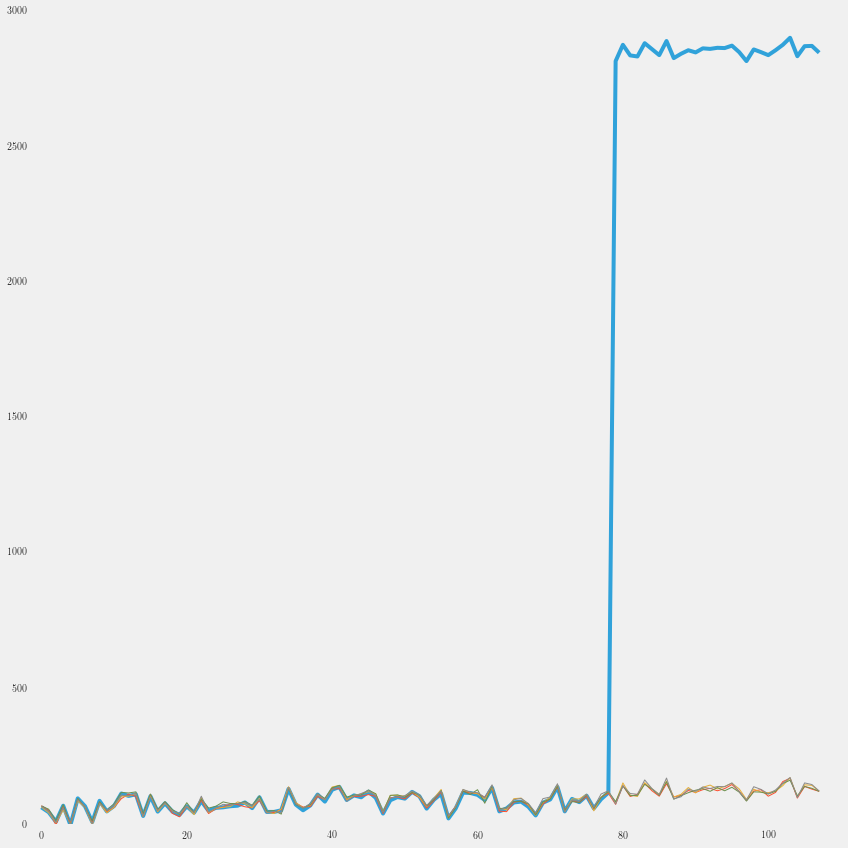

In [814]:
x0, y0  = flags_loc[2808]#413, 176
print(x0, y0)
meandark = np.mean([darks[:,x0+1, y0+0]*std(darks[:,x0+1, y0+0]),darks[:,x0-1, y0+0]*std(darks[:,x0-1, y0+0]), \
                    darks[:,x0+0, y0+1]*std(darks[:,x0+0, y0+1]),darks[:,x0+0, y0-1]*std(darks[:,x0+0, y0-1])], axis=0)
# 160 335
# 159 335
# 161 335
# 160 334
# 160 336
# meandark = np.mean([darks[:,159, 335],darks[:,161, 335], darks[:,160, 334],darks[:,160, 336]],axis=0)

# meddark  = np.median([darks[:,159, 335]*std(darks[:,159, 335]),darks[:,161, 335]*std(darks[:,161, 335]), \
#               darks[:,160, 334]*std(darks[:,160, 334]),darks[:,160, 336]*std(darks[:,160, 336])],axis=0)

# meandark = np.mean([darks[:,159, 335]*std(darks[:,159, 335]),darks[:,161, 335]*std(darks[:,161, 335]), \
#                     darks[:,160, 334]*std(darks[:,160, 334]),darks[:,160, 336]*std(darks[:,160, 336])], axis=0)

fig = figure(figsize=(12,12))
plot((darks[:,x0, y0] - np.min(darks[:,x0, y0])), lw=4)
# plot((meandark / np.min(meandark)), lw=4)

# plot((meddark  - meddark.min())  / (meddark.max()  - meddark.min() ), lw=4)

plot((darks[:,x0+1, y0+0]) - np.min((darks[:,x0+1, y0+0])))
plot((darks[:,x0-1, y0+0]) - np.min((darks[:,x0-1, y0+0])))
plot((darks[:,x0+0, y0+1]) - np.min((darks[:,x0+0, y0+1])))
plot((darks[:,x0+0, y0-1]) - np.min((darks[:,x0+0, y0-1])))
xlim(-1,110)

1115 1133


/Users/jonathanfraine/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


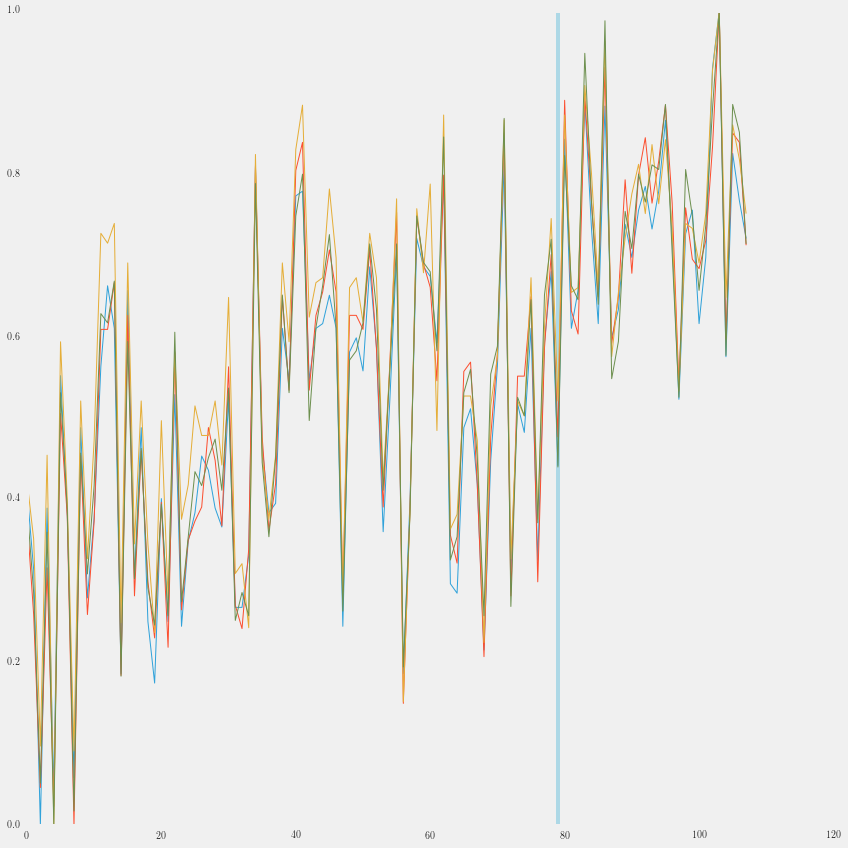

In [818]:
x0, y0  = flags_loc[2808]#413, 176
print(x0, y0)
meandark = np.mean([darks[:,x0+1, y0+0]*std(darks[:,x0+1, y0+0]),darks[:,x0-1, y0+0]*std(darks[:,x0-1, y0+0]), \
                    darks[:,x0+0, y0+1]*std(darks[:,x0+0, y0+1]),darks[:,x0+0, y0-1]*std(darks[:,x0+0, y0-1])], axis=0)
# 160 335
# 159 335
# 161 335
# 160 334
# 160 336
# meandark = np.mean([darks[:,159, 335],darks[:,161, 335], darks[:,160, 334],darks[:,160, 336]],axis=0)

# meddark  = np.median([darks[:,159, 335]*std(darks[:,159, 335]),darks[:,161, 335]*std(darks[:,161, 335]), \
#               darks[:,160, 334]*std(darks[:,160, 334]),darks[:,160, 336]*std(darks[:,160, 336])],axis=0)

# meandark = np.mean([darks[:,159, 335]*std(darks[:,159, 335]),darks[:,161, 335]*std(darks[:,161, 335]), \
#                     darks[:,160, 334]*std(darks[:,160, 334]),darks[:,160, 336]*std(darks[:,160, 336])], axis=0)
fig = figure(figsize=(12,12))
# plot(rescale(darks[:,x0, y0]), lw=4)
# plot(rescale(meandark), lw=4)

# plot((meddark  - meddark.min())  / (meddark.max()  - meddark.min() ), lw=4)

axvline(argmax(diff(rescale(darks[:,x0, y0])))+1,lw=4)
plot(rescale(darks[:,x0+1, y0+0]))
plot(rescale(darks[:,x0-1, y0+0]))
plot(rescale(darks[:,x0+0, y0+1]))
plot(rescale(darks[:,x0+0, y0-1]))

In [1147]:
def rescale(arr):
    if arr.max() != arr.min():
        return (arr - arr.min()) / (arr.max() - arr.min())
    else:
        return np.zeros(arr.size)

In [975]:
# quirkCheck = np.zeros(len(quirks_store))

In [1051]:
np.savetxt('quirkCheck_save_bkup.txt', quirkCheck)

In [1057]:
np.sum(quirkCheck == 8) + np.sum(quirkCheck == 7), np.sum(quirkCheck == 1)

(97, 41)

In [990]:
quirkCheck[:100]

array([ 1.,  7.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  7.,
        0.,  0.,  0.,  6.,  6.,  0.,  0.,  0.,  6.,  6.,  0.,  0.,  0.,
        6.,  6.,  0.,  6.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [1045]:
quirkCheck[np.where((quirkCheck == 1)*(arange(quirkCheck.size)<4815))[0].max()] = 0

In [1027]:
quirkCheck[3315] = 0

In [1003]:
quirkCheck[np.where(quirkCheck ==0)[0].min()-1] = 0.0

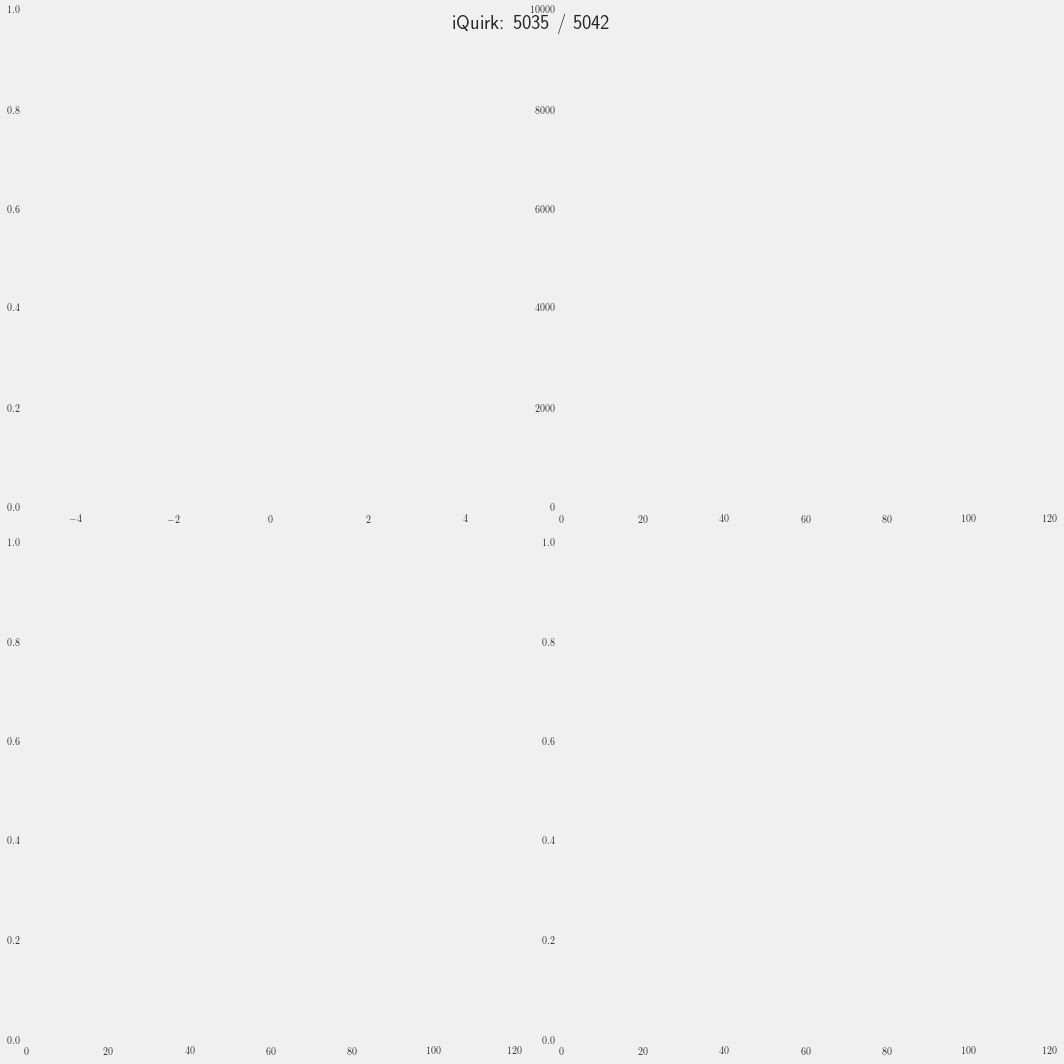

In [1050]:
fig = figure(figsize=(15,15))

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

# fig = figure(figsize=(15,5))
# ax1 = fig.add_subplot(141)
# ax2 = fig.add_subplot(142)
# ax3 = fig.add_subplot(143)
# ax4 = fig.add_subplot(144)

darkMed = darks_flat_med_axis0 - np.min(darks_flat_med_axis0)
darksMed_scaled = darks_flat_med_axis0 / median(darks_flat_med_axis0)# pp.scale(darks_flat_med_axis0)

diff_darks_flat_med_axis0     = np.zeros(darks_flat_med_axis0.size)
diff_darks_flat_med_axis0[1:] = diff(darks_flat_med_axis0)

classLabels = {1:'Noisy', 2:'HP', 3:'IHP', 4:'LHP', 5:'SHP', 6:'CR', 7:'RTN0', 8:'RTN1'}
np.savetxt('quirkCheck_save_bkup.txt', quirkCheck)
for iQuirk, quirkNow in enumerate(quirks_store):
    if quirkCheck[iQuirk]:
        continue
    
    ax1.clear()
    ax2.clear()
    ax3.clear()
    ax4.clear()
    
    classNow = classes_store[iQuirk]
    classOut = classNow
    if classNow == 3:
        classOut = 7
    if classNow == 4:
        classOut = 6
    if classNow == 5:
        classOut = 5
    if classNow == 6:
        classOut = 3
    if classOut in [1,6]:
        pass
    else:
        quirkCheck[iQuirk] = int(classOut)
        continue
    
    # ax1.plot(darks_reshaped[irow][1:] / median(darks_reshaped[irow][1:]) - darks_flat_med_axis0_norm);
    
    # Plot Subtraction frame: (Darknow - min(Darknow)) - (DarkMed - min(DarkMed))
    # darkNowMinusMed = (darks_reshaped[irow][1:] - np.min(darks_reshaped[irow][1:])) - \
    #                   (darks_flat_med_axis0[1:] - np.min(darks_flat_med_axis0[1:]))
    
    quirkNow_scaled = pp.scale(quirkNow)
    
    quirkMinusMed = (quirkNow_scaled - np.min(quirkNow_scaled)) - (darksMed_scaled - np.min(darksMed_scaled))
    
    quirkNowRescaled = pp.scale((quirkNow - np.min(quirkNow))-(darks_flat_med_axis0 - np.min(darks_flat_med_axis0)))
    _, xhist = np.histogram(quirkNowRescaled, bins=20, normed=True)#, alpha=0.50)
    
    kde1 = sm.nonparametric.KDEUnivariate(quirkNowRescaled)
    kde1.fit(kernel='uni', bw=0.33*median(diff(xhist)), fft=False)
    
    ax1.plot(kde1.support, rescale(kde1.density), lw=2, color=rcParams['axes.color_cycle'][0], label='QuirkNow Rescaled')
    
    # if classNow == 1:
    #ax1.hist(pp.scale(darks_flat_med_axis0), bins=20, normed=True, alpha=0.25, label='DarksMed Rescaled')
    kde2 = sm.nonparametric.KDEUnivariate(pp.scale(darks_flat_med_axis0))
    kde2.fit(kernel='uni', fft=False)
    ax1.plot(kde2.support, rescale(kde2.density), lw=2, color=rcParams['axes.color_cycle'][1], label='DarksMed Rescaled')
    
    leave1out = np.zeros(nFrames)
    for k in range(nFrames):
        leave1out[k] = np.std(hstack([quirkNow[:k],quirkNow[k+1:]]))
    
    #ax1.hist(pp.scale(np.std(quirkNow) - leave1out), bins=20, alpha=0.5, normed=True, label='Leave1Out Rescaled');
    kde3 = sm.nonparametric.KDEUnivariate(pp.scale(np.std(quirkNow) - leave1out))
    kde3.fit(kernel='uni', fft=False)
    ax1.plot(kde3.support, rescale(kde3.density), lw=2, color=rcParams['axes.color_cycle'][2], label='Leave1Out Rescaled')
    ax1.legend()
    # else:
    #     ax1.hist((darksAvg - np.median(darksAvg)), bins=20, normed=True, alpha=0.25)
    #     kde2 = sm.nonparametric.KDEUnivariate((darksAvg - np.median(darksAvg)))
    #     kde2.fit(kernel='uni', fft=False)
    #     ax1.plot(kde2.support, kde2.density, lw=2, color=rcParams['axes.color_cycle'][1])

    ylims = ax1.get_ylim()
    xlims = ax1.get_xlim()
    xyNow1 = [np.min(xlims) + 0.1*diff(xlims),
              np.min(ylims) + 0.9*diff(ylims)]
    
    annString = str(int(classOut)) + ': ' + classLabels[classOut]
    ax1.annotate(annString, xyNow1, fontsize=75)
    # ax1.plot()
    # ax1.axvline(median(rtnNow), linestyle='--', color='k')
    ax1.set_xlabel('Subtraction Hist')
    # ax1.plot(darks_reshaped[irow][1:] / median(darks_reshaped[irow][1:]) / darks_flat_med_axis0_norm - 1);
    
    # Plot Normalized Frame: DarkNow vs DarMed
    ax2.plot((quirkNow - np.min(quirkNow))/darksMed_scaled,'o-');
    ylims = ax2.get_ylim()
    xlims = ax2.get_xlim()
    xyNow2 = [np.min(xlims) + 0.1*diff(xlims),
              np.min(ylims) + 0.9*diff(ylims)]
    ax2.annotate(annString, xyNow2, fontsize=75)
    #ax2.plot(darksMed_scaled,'o-')
    ax2.set_xlabel('Normalized Frame')
    
    # Plot Common Mode Correlation Frame
    # ax3.plot((quirkNow - np.min(quirkNow))-(darks_flat_med_axis0 - np.min(darks_flat_med_axis0)), darksMed_scaled,'o')
    # ax3.plot(darksMed_scaled, darksMed_scaled,'o')
    ax3.plot(rescale(diff(quirkNow)),'o-')
    ax3.plot(rescale(diff_darks_flat_med_axis0), 'o-', alpha=0.25)
    ax3.axhline(np.median(rescale(diff_darks_flat_med_axis0)), c='k', lw=1)
    ax3.axhline(np.median(rescale(diff_darks_flat_med_axis0))+np.std(rescale(diff_darks_flat_med_axis0)), c='k', lw=1,ls='--')
    ax3.axhline(np.median(rescale(diff_darks_flat_med_axis0))-np.std(rescale(diff_darks_flat_med_axis0)), c='k', lw=1,ls='--')
    ylims = ax3.get_ylim()
    xlims = ax3.get_xlim()
    xyNow3 = [np.min(xlims) + 0.1*diff(xlims),
              np.min(ylims) + 0.9*diff(ylims)]
    ax3.annotate(annString, xyNow3, fontsize=75)
    ax3.set_xlabel('Diff Mode')
    
    # Plot Raw DN minus Min Dark Ramp: DarkNow - min(DarkNow) vs DarkMed - min(DarkMed)
    flagNow = flags_loc[iQuirk]
    dark0   = quirkNow - np.min(quirkNow)
    # ax4.plot(rescale((dark0 + diff_darks_flat_med_axis0)),'o-', color=rcParams['axes.color_cycle'][0])
    ax4.plot(rescale((dark0 - diff_darks_flat_med_axis0)),'o-', color=rcParams['axes.color_cycle'][0])
    
    avgCnt   = 0
    darksAvg = np.zeros(quirkNow.size)
    if flagNow[0] > 0:
        avgCnt   += 1
        darksAvg += (darks[:,flagNow[0]-1, flagNow[1]+0] - diff_darks_flat_med_axis0) * std(darks[:,flagNow[0]-1, flagNow[1]+0])
        
        # ax4.plot(rescale(darks[:,flagNow[0]-1, flagNow[1]+0]),'o-')
    if flagNow[0] + 1 < darks.shape[1]:
        avgCnt   += 1
        darksAvg += (darks[:,flagNow[0]+1, flagNow[1]+0] - diff_darks_flat_med_axis0) * std(darks[:,flagNow[0]+1, flagNow[1]+0])
        
        # ax4.plot(rescale(darks[:,flagNow[0]+1, flagNow[1]+0]),'o-')
    if flagNow[1] > 0:
        avgCnt   += 1
        darksAvg += (darks[:,flagNow[0]+0, flagNow[1]-1] - diff_darks_flat_med_axis0) * std(darks[:,flagNow[0]+0, flagNow[1]-1])
        
        # ax4.plot(rescale(darks[:,flagNow[0]+0, flagNow[1]-1]),'o-')
    if flagNow[1] + 1 < darks.shape[1]:
        avgCnt   += 1
        darksAvg += (darks[:,flagNow[0]+0, flagNow[1]+1] - diff_darks_flat_med_axis0) * std(darks[:,flagNow[0]+0, flagNow[1]+1])
        
        # ax4.plot(rescale(darks[:,flagNow[0]+0, flagNow[1]+1]),'o-',lw=4)
    
    darksAvg  = darksAvg / avgCnt
    
    ax4.plot(rescale(darksAvg), 'o-', color=rcParams['axes.color_cycle'][3])
    # ax2.plot((darksAvg - np.min(darksAvg))/darksMed_scaled,'o-');
    ylims = ax4.get_ylim()
    xlims = ax4.get_xlim()
    xyNow4 = [np.min(xlims) + 0.1*diff(xlims),
              np.min(ylims) + 0.9*diff(ylims)]
    ax4.annotate(annString, xyNow4, fontsize=75)
    
    ax4.set_xlabel('Rescaled Nearby Pixels ' + str(flagNow[0]) + ',' + str(flagNow[1]))
    # ax4.set_ylim(-5,5)
    # ax.plot(darks_flat_med_axis0[1:] / median(darks_flat_med_axis0[1:]))
    fig.suptitle('iQuirk: ' + str(iQuirk) + ' / ' + str(len(quirks_store)), fontsize=20)
    # ax1.set_ylim(ax2.get_ylim())
    fig.canvas.draw()
    display.display(plt.gcf())
    
    inputNow = input('[1:Noisy, 2:HP, 3:IHP, 4:LHP, 5:SHP, 6:CR, 7:RTN0, 8:RTN1]? ')
    
    # inputNowBak = np.copy(inputNow)
    quirkCheck[iQuirk] = int(classOut)
    # print('Keeping ' + str(iQuirk) + ' as ' + str(quirkCheck[iQuirk]))
    if inputNow == '':
        pass
    else:
        classOut = int(inputNow)
        
        doubleCheck = input(str(classNow) + " -> " + str(classOut) + "? ")
        
        #doubleCheck != '' and {'y':True, 'n':False}[doubleCheck.lower()[0]]:
        if doubleCheck.lower()[0] == 'y':
            quirkCheck[iQuirk] = int(classOut)
            
    display.clear_output(wait=True)

In [1058]:
# rtnCheck = np.zeros(len(rtn_syn))

In [ ]:
rtnCheck[np.where(rtnCheck ==0)[0].min()-1] = 0.0

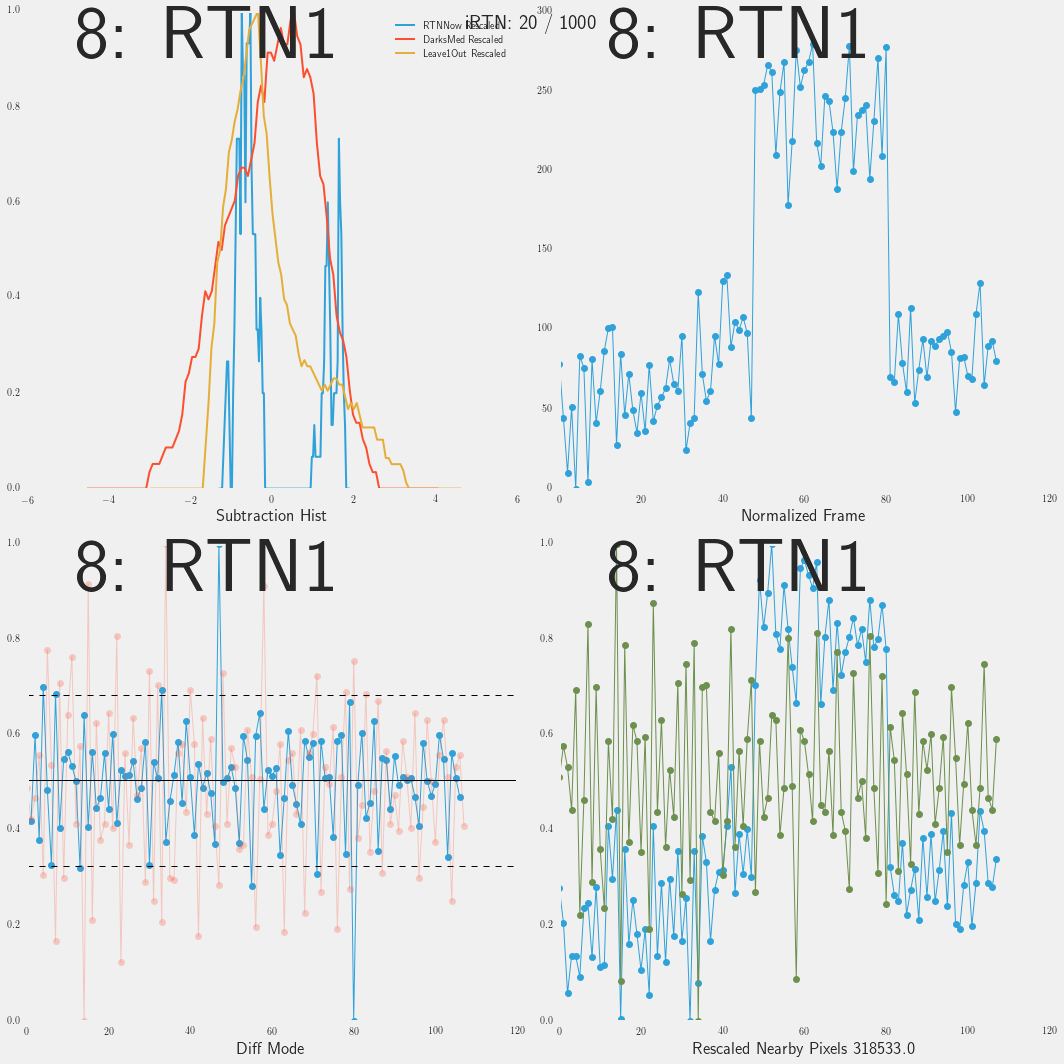

KeyboardInterrupt: 

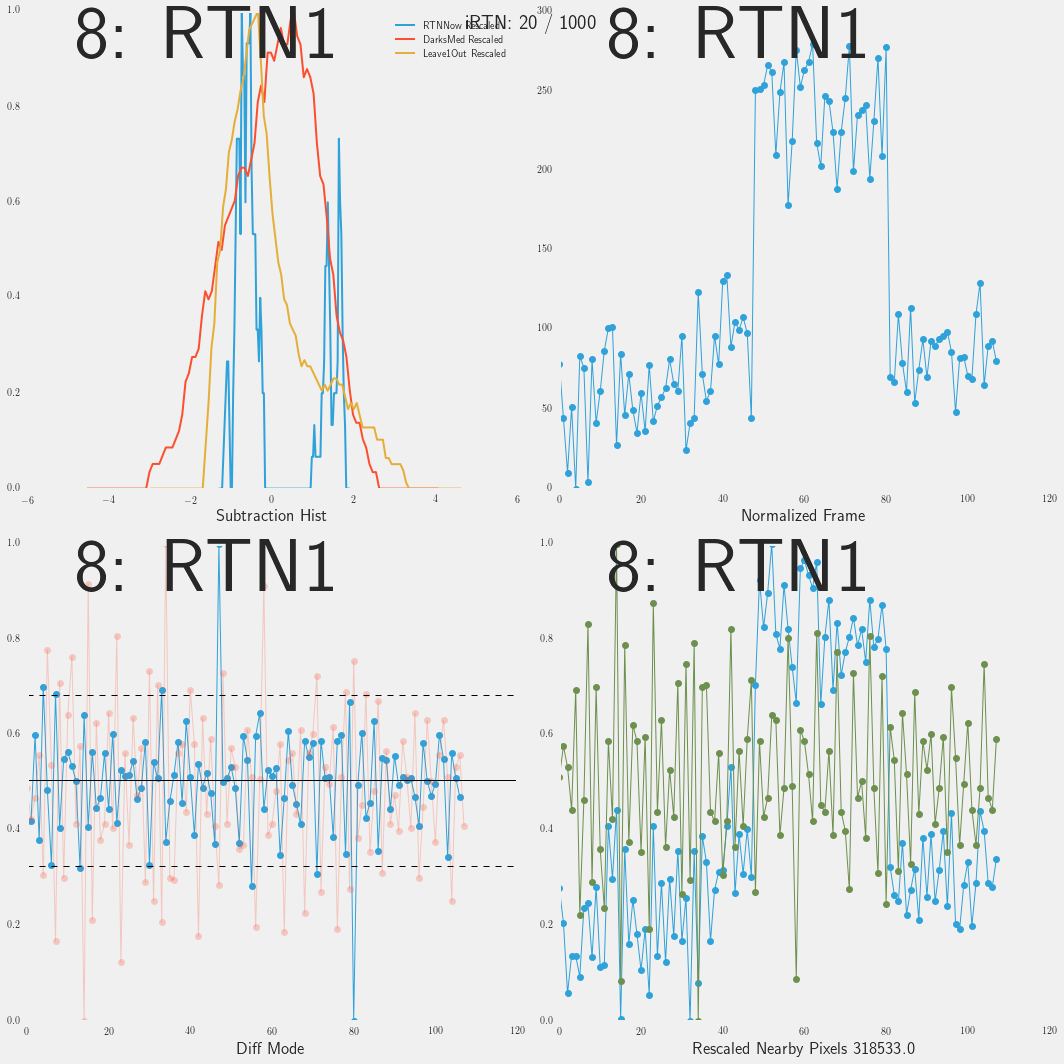

In [1094]:
fig = figure(figsize=(15,15))

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

# fig = figure(figsize=(15,5))
# ax1 = fig.add_subplot(141)
# ax2 = fig.add_subplot(142)
# ax3 = fig.add_subplot(143)
# ax4 = fig.add_subplot(144)

darkMed = darks_flat_med_axis0 - np.min(darks_flat_med_axis0)
darksMed_scaled = darks_flat_med_axis0 / median(darks_flat_med_axis0)# pp.scale(darks_flat_med_axis0)

diff_darks_flat_med_axis0     = np.zeros(darks_flat_med_axis0.size)
diff_darks_flat_med_axis0[1:] = diff(darks_flat_med_axis0)

classLabels = {1:'Noisy', 2:'HP', 3:'IHP', 4:'LHP', 5:'SHP', 6:'CR', 7:'RTN0', 8:'RTN1'}
np.savetxt('rtnCheck_save_bkup.txt', rtnCheck)
for iRTN, rtnNow in enumerate(rtn_syn):
    if rtnCheck[iRTN]:
        continue
    
    ax1.clear()
    ax2.clear()
    ax3.clear()
    ax4.clear()
    
    # classNow = classes_store[iRTN]
    classNow = rtn_classes[iRTN] + 7
    classOut = classNow
    if classNow == 3:
        classOut = 7
    if classNow == 4:
        classOut = 6
    if classNow == 5:
        classOut = 5
    if classNow == 6:
        classOut = 3
    
    rtnNow_scaled = pp.scale(rtnNow)
    
    rtnMinusMed = (rtnNow_scaled - np.min(rtnNow_scaled)) - (darksMed_scaled - np.min(darksMed_scaled))
    
    rtnNowRescaled = pp.scale((rtnNow - np.min(rtnNow))-(darks_flat_med_axis0 - np.min(darks_flat_med_axis0)))
    _, xhist = np.histogram(rtnNowRescaled, bins=20, normed=True)#, alpha=0.50)
    
    kde1 = sm.nonparametric.KDEUnivariate(rtnNowRescaled)
    kde1.fit(kernel='uni', bw=0.33*median(diff(xhist)), fft=False)
    
    ax1.plot(kde1.support, rescale(kde1.density), lw=2, color=rcParams['axes.color_cycle'][0], label='RTNNow Rescaled')
    
    kde2 = sm.nonparametric.KDEUnivariate(pp.scale(darks_flat_med_axis0))
    kde2.fit(kernel='uni', fft=False)
    ax1.plot(kde2.support, rescale(kde2.density), lw=2, color=rcParams['axes.color_cycle'][1], label='DarksMed Rescaled')
    
    leave1out = np.zeros(nFrames)
    for k in range(nFrames):
        leave1out[k] = np.std(hstack([rtnNow[:k],rtnNow[k+1:]]))
    
    kde3 = sm.nonparametric.KDEUnivariate(pp.scale(np.std(rtnNow) - leave1out))
    kde3.fit(kernel='uni', fft=False)
    ax1.plot(kde3.support, rescale(kde3.density), lw=2, color=rcParams['axes.color_cycle'][2], label='Leave1Out Rescaled')
    ax1.legend()
    
    ylims = ax1.get_ylim()
    xlims = ax1.get_xlim()
    xyNow1 = [np.min(xlims) + 0.1*diff(xlims),
              np.min(ylims) + 0.9*diff(ylims)]
    
    annString = str(int(classOut)) + ': ' + classLabels[classOut]
    ax1.annotate(annString, xyNow1, fontsize=75)
    
    ax1.set_xlabel('Subtraction Hist')
    
    # Plot Normalized Frame: DarkNow vs DarMed
    ax2.plot((rtnNow - np.min(rtnNow))/darksMed_scaled,'o-');
    ylims = ax2.get_ylim()
    xlims = ax2.get_xlim()
    xyNow2 = [np.min(xlims) + 0.1*diff(xlims),
              np.min(ylims) + 0.9*diff(ylims)]
    ax2.annotate(annString, xyNow2, fontsize=75)
    
    ax2.set_xlabel('Normalized Frame')
    
    # Plot Common Mode Correlation Frame
    ax3.plot(rescale(diff(rtnNow)),'o-')
    ax3.plot(rescale(diff_darks_flat_med_axis0), 'o-', alpha=0.25)
    ax3.axhline(np.median(rescale(diff_darks_flat_med_axis0)), c='k', lw=1)
    ax3.axhline(np.median(rescale(diff_darks_flat_med_axis0))+np.std(rescale(diff_darks_flat_med_axis0)), c='k', lw=1,ls='--')
    ax3.axhline(np.median(rescale(diff_darks_flat_med_axis0))-np.std(rescale(diff_darks_flat_med_axis0)), c='k', lw=1,ls='--')
    ylims = ax3.get_ylim()
    xlims = ax3.get_xlim()
    xyNow3 = [np.min(xlims) + 0.1*diff(xlims),
              np.min(ylims) + 0.9*diff(ylims)]
    ax3.annotate(annString, xyNow3, fontsize=75)
    ax3.set_xlabel('Diff Mode')
    
    # Plot Raw DN minus Min Dark Ramp: DarkNow - min(DarkNow) vs DarkMed - min(DarkMed)
    flagNow = rtn_loc[iRTN]
    dark0   = rtnNow - np.min(rtnNow)
    
    ax4.plot(rescale((dark0 - diff_darks_flat_med_axis0)),'o-', color=rcParams['axes.color_cycle'][0])
    
    avgCnt   = 0
    darksAvg = np.zeros(rtnNow.size)
    if flagNow > 0:
        avgCnt   += 1
        darksAvg += (darks_norm_flat[flagNow-1] - diff_darks_flat_med_axis0) * std(darks_norm_flat[flagNow-1])
        
    if flagNow + 1 < darks_norm_flat.shape[0]:
        avgCnt   += 1
        darksAvg += (darks_norm_flat[flagNow+1] - diff_darks_flat_med_axis0) * std(darks_norm_flat[flagNow+1])
        
    if flagNow > 2048:
        avgCnt   += 1
        darksAvg += (darks_norm_flat[flagNow-2048] - diff_darks_flat_med_axis0) * std(darks_norm_flat[flagNow-2048])
        
    if flagNow + 2048 < darks_norm_flat.shape[0]:
        avgCnt   += 1
        darksAvg += (darks_norm_flat[flagNow+2048] - diff_darks_flat_med_axis0) * std(darks_norm_flat[flagNow+2048])
        
    darksAvg  = darksAvg / avgCnt
    
    ax4.plot(rescale(darksAvg), 'o-', color=rcParams['axes.color_cycle'][3])
    
    ylims = ax4.get_ylim()
    xlims = ax4.get_xlim()
    xyNow4 = [np.min(xlims) + 0.1*diff(xlims),
              np.min(ylims) + 0.9*diff(ylims)]
    ax4.annotate(annString, xyNow4, fontsize=75)
    
    ax4.set_xlabel('Rescaled Nearby Pixels ' + str(flagNow))
    
    fig.suptitle('iRTN: ' + str(iRTN) + ' / ' + str(len(rtn_syn)), fontsize=20)
    
    fig.canvas.draw()
    display.display(plt.gcf())
    
    inputNow = input('[1:Noisy, 2:HP, 3:IHP, 4:LHP, 5:SHP, 6:CR, 7:RTN0, 8:RTN1]? ')
    
    
    rtnCheck[iRTN] = int(classOut)
    
    if inputNow == '':
        pass
    else:
        classOut = int(inputNow)
        
        doubleCheck = input(str(classNow) + " -> " + str(classOut) + "? ")
        
        if doubleCheck.lower()[0] == 'y':
            rtnCheck[iRTN] = int(classOut)
            
    display.clear_output(wait=True)

In [1148]:
# darkMed = darks_flat_med_axis0 - np.min(darks_flat_med_axis0)
# darksMed_scaled = darks_flat_med_axis0 / median(darks_flat_med_axis0)# pp.scale(darks_flat_med_axis0)

diff_darks_flat_med_axis0     = np.zeros(darks_flat_med_axis0.size)
diff_darks_flat_med_axis0[1:] = diff(darks_flat_med_axis0)

rtn_features  = []

for iRTN, rtnNow in enumerate(rtn_syn):
    
    rtnNowRescaled = pp.scale((rtnNow - np.min(rtnNow))-(darks_flat_med_axis0 - np.min(darks_flat_med_axis0)))
    _, xhist = np.histogram(rtnNowRescaled, bins=20, normed=True)#, alpha=0.50)
    
    kde1 = sm.nonparametric.KDEUnivariate(rtnNowRescaled)
    kde1.fit(kernel='uni', bw=0.33*median(diff(xhist)), fft=False)
    
    leave1out = np.zeros(nFrames)
    for k in range(nFrames):
        leave1out[k] = np.std(hstack([rtnNow[:k],rtnNow[k+1:]]))
    
    leave1out_rescaled  = rescale(leave1out)
    
    kde3 = sm.nonparametric.KDEUnivariate(pp.scale(np.std(rtnNow) - leave1out))
    kde3.fit(kernel='uni', fft=False)
    
    rtnNowRescaled_KDE = rescale(kde1.density)
    l1o_Rescaled_KDE   = rescale(kde3.density)
    
    rtnDiffRescale    = rescale(diff(rtnNow))
    
    flagNow = rtn_loc[iRTN]
    # print(flagNow)
    rtn0    = rtnNow - np.min(rtnNow)
    
    rtn0_rescaled = rescale(rtn0 - diff_darks_flat_med_axis0)
    
    avgCnt   = 0
    darksAvg = np.zeros(rtnNow.size)
    if flagNow > 0:
        avgCnt   += 1
        darksAvg += (darks_norm_flat[flagNow-1] - diff_darks_flat_med_axis0) * std(darks_norm_flat[flagNow-1])
        
    if flagNow + 1 < darks_norm_flat.shape[0]:
        avgCnt   += 1
        darksAvg += (darks_norm_flat[flagNow+1] - diff_darks_flat_med_axis0) * std(darks_norm_flat[flagNow+1])
        
    if flagNow > 2048:
        avgCnt   += 1
        darksAvg += (darks_norm_flat[flagNow-2048] - diff_darks_flat_med_axis0) * std(darks_norm_flat[flagNow-2048])
        
    if flagNow + 2048 < darks_norm_flat.shape[0]:
        avgCnt   += 1
        darksAvg += (darks_norm_flat[flagNow+2048] - diff_darks_flat_med_axis0) * std(darks_norm_flat[flagNow+2048])
    
    darksAvg  = darksAvg / avgCnt
    
    darksAvg_rescaled = rescale(darksAvg)
    
    rtn_features.append(hstack([rtn0_rescaled, rtnNowRescaled_KDE, l1o_Rescaled_KDE, leave1out_rescaled, rtnDiffRescale, darksAvg_rescaled]))

/Users/jonathanfraine/anaconda/lib/python3.5/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)
/Users/jonathanfraine/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:41: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/jonathanfraine/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/jonathanfraine/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:49: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/jonathanfraine/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:53: VisibleDeprecationWarning: using a non-integer number instead of an integer will resu

In [1149]:
rtn_features = np.array(rtn_features)

In [1150]:
rtn_features.min(), rtn_features.max()

(0.0, 1.0)

In [1152]:
# darkMed = darks_flat_med_axis0 - np.min(darks_flat_med_axis0)
# darksMed_scaled = darks_flat_med_axis0 / median(darks_flat_med_axis0)# pp.scale(darks_flat_med_axis0)

diff_darks_flat_med_axis0     = np.zeros(darks_flat_med_axis0.size)
diff_darks_flat_med_axis0[1:] = diff(darks_flat_med_axis0)

quirk_features  = []

for iQuirk, quirkNow in enumerate(quirks_store):
    
    quirkNowRescaled = pp.scale((quirkNow - np.min(quirkNow))-(darks_flat_med_axis0 - np.min(darks_flat_med_axis0)))
    _, xhist = np.histogram(quirkNowRescaled, bins=20, normed=True)#, alpha=0.50)
    
    kde1 = sm.nonparametric.KDEUnivariate(quirkNowRescaled)
    kde1.fit(kernel='uni', bw=0.33*median(diff(xhist)), fft=False)
    
    leave1out = np.zeros(nFrames)
    for k in range(nFrames):
        leave1out[k] = np.std(hstack([quirkNow[:k],quirkNow[k+1:]]))
    
    leave1out_rescaled  = rescale(leave1out)
    
    kde3 = sm.nonparametric.KDEUnivariate(pp.scale(np.std(quirkNow) - leave1out))
    kde3.fit(kernel='uni', fft=False)
    
    quirkNowRescaled_KDE = rescale(kde1.density)
    l1o_Rescaled_KDE   = rescale(kde3.density)
    
    quirkDiffRescale    = rescale(diff(quirkNow))
    
    quirk0    = quirkNow - np.min(quirkNow)
    
    quirk0_rescaled = rescale(quirk0 - diff_darks_flat_med_axis0)
    
    flagNow = flags_loc[iQuirk]
    avgCnt   = 0
    darksAvg = np.zeros(quirkNow.size)
    if flagNow[0] > 0:
        avgCnt   += 1
        darksAvg += (darks[:,flagNow[0]-1, flagNow[1]+0] - diff_darks_flat_med_axis0) * std(darks[:,flagNow[0]-1, flagNow[1]+0])
        
    if flagNow[0] + 1 < darks.shape[1]:
        avgCnt   += 1
        darksAvg += (darks[:,flagNow[0]+1, flagNow[1]+0] - diff_darks_flat_med_axis0) * std(darks[:,flagNow[0]+1, flagNow[1]+0])
        
    if flagNow[1] > 0:
        avgCnt   += 1
        darksAvg += (darks[:,flagNow[0]+0, flagNow[1]-1] - diff_darks_flat_med_axis0) * std(darks[:,flagNow[0]+0, flagNow[1]-1])
        
    if flagNow[1] + 1 < darks.shape[1]:
        avgCnt   += 1
        darksAvg += (darks[:,flagNow[0]+0, flagNow[1]+1] - diff_darks_flat_med_axis0) * std(darks[:,flagNow[0]+0, flagNow[1]+1])
    
    
    darksAvg  = darksAvg / avgCnt
    
    darksAvg_rescaled = rescale(darksAvg)
    
    quirk_features.append(hstack([quirk0_rescaled, quirkNowRescaled_KDE, l1o_Rescaled_KDE, leave1out_rescaled, quirkDiffRescale, darksAvg_rescaled]))

/Users/jonathanfraine/anaconda/lib/python3.5/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)


In [1155]:
quirk_features = np.array(quirk_features)

In [1156]:
quirk_features.min(), quirk_features.max()

(0.0, 1.0)

In [1159]:
np.random.seed(42)
nFlatDarks        = 5000
df_inds           = np.arange(darks_flat.shape[0])
df_sample         = np.random.choice(df_inds, nFlatDarks, replace=False)
darks_flat_sample = np.copy(darks_flat[df_sample])

/Users/jonathanfraine/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


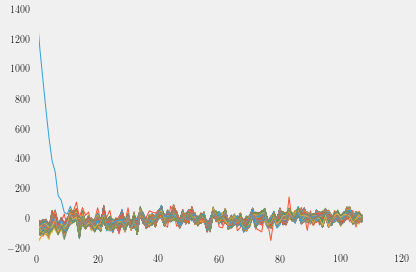

In [1160]:
plot(darks_flat_sample.T - median(darks_flat_sample,axis=1));

In [1161]:
darks_flat_sample.shape

(5000, 108)

In [1162]:
for k in range(darks_flat_sample.shape[0]):
    if (darks_flat_sample[k] - median(darks_flat_sample[k]) > 200).any():
        print(k)

850


In [1163]:
std(abs(darks_flat_sample[850] / median(darks_flat_sample[850]))-1), 2*darks_med_std

(0.0051697831038977913, 0.0079730175048939797)

In [1164]:
darks_flat_sample0 = darks_flat_sample.copy()
darks_flat_sample = vstack([darks_flat_sample0[:850], darks_flat_sample0[851:]])#.shape

In [1170]:
# darkMed = darks_flat_med_axis0 - np.min(darks_flat_med_axis0)
# darksMed_scaled = darks_flat_med_axis0 / median(darks_flat_med_axis0)# pp.scale(darks_flat_med_axis0)

diff_darks_flat_med_axis0     = np.zeros(darks_flat_med_axis0.size)
diff_darks_flat_med_axis0[1:] = diff(darks_flat_med_axis0)

dark_features  = []

for iDark, darkNow in enumerate(darks_flat_sample):
    
    darkNowRescaled = pp.scale((darkNow - np.min(darkNow))-(darks_flat_med_axis0 - np.min(darks_flat_med_axis0)))
    _, xhist = np.histogram(darkNowRescaled, bins=20, normed=True)#, alpha=0.50)
    
    kde1 = sm.nonparametric.KDEUnivariate(darkNowRescaled)
    kde1.fit(kernel='uni', bw=0.33*median(diff(xhist)), fft=False)
    
    leave1out = np.zeros(nFrames)
    for k in range(nFrames):
        leave1out[k] = np.std(hstack([darkNow[:k],darkNow[k+1:]]))
    
    leave1out_rescaled  = rescale(leave1out)
    
    kde3 = sm.nonparametric.KDEUnivariate(pp.scale(np.std(darkNow) - leave1out))
    kde3.fit(kernel='uni', fft=False)
    
    darkNowRescaled_KDE = rescale(kde1.density)
    l1o_Rescaled_KDE   = rescale(kde3.density)
    
    darkDiffRescale    = rescale(diff(darkNow))
    
    dark0    = darkNow - np.min(darkNow)
    
    dark0_rescaled = rescale(dark0 - diff_darks_flat_med_axis0)
    
    flagNow = df_sample[iDark]
    avgCnt   = 0
    darksAvg = np.zeros(rtnNow.size)
    if flagNow > 0:
        avgCnt   += 1
        darksAvg += (darks_norm_flat[flagNow-1] - diff_darks_flat_med_axis0) * std(darks_norm_flat[flagNow-1])
        
    if flagNow + 1 < darks_norm_flat.shape[0]:
        avgCnt   += 1
        darksAvg += (darks_norm_flat[flagNow+1] - diff_darks_flat_med_axis0) * std(darks_norm_flat[flagNow+1])
        
    if flagNow > 2048:
        avgCnt   += 1
        darksAvg += (darks_norm_flat[flagNow-2048] - diff_darks_flat_med_axis0) * std(darks_norm_flat[flagNow-2048])
        
    if flagNow + 2048 < darks_norm_flat.shape[0]:
        avgCnt   += 1
        darksAvg += (darks_norm_flat[flagNow+2048] - diff_darks_flat_med_axis0) * std(darks_norm_flat[flagNow+2048])
    
    darksAvg  = darksAvg / avgCnt
    
    darksAvg_rescaled = rescale(darksAvg)
    
    dark_features.append(hstack([dark0_rescaled, darkNowRescaled_KDE, l1o_Rescaled_KDE, leave1out_rescaled, darkDiffRescale, darksAvg_rescaled]))

/Users/jonathanfraine/anaconda/lib/python3.5/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)


In [1171]:
dark_features = np.array(dark_features)

In [1172]:
dark_features.min(), dark_features.max()

(0.0, 1.0)

/Users/jonathanfraine/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


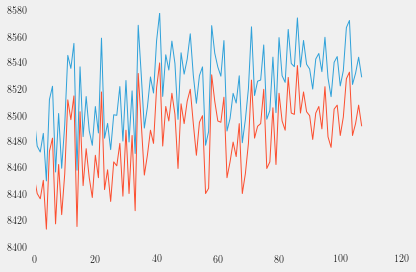

In [1105]:
plot(np.mean(darks_flat,axis=0));
plot(np.median(darks_flat,axis=0));

In [1106]:
np.median(darks_flat,axis=0).shape

(108,)

In [1107]:
darks_flat_std_axis1.shape

(4188264,)

In [1108]:
darks_flat_med_axis0.shape,darks_flat_med_axis1.shape

((108,), (4188264,))

In [1109]:
darks_flat_sample_med1 = np.median(darks_flat_sample,axis=1)

In [1110]:
print(darks_flat_med_axis0.shape, darks_flat_sample_med1.shape)

(108,) (4998,)


In [1111]:
darks_flat_sample.shape

(4998, 108)

/Users/jonathanfraine/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/Users/jonathanfraine/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype uint16 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/Users/jonathanfraine/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


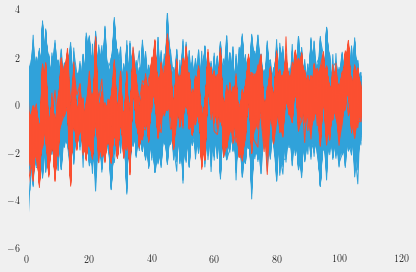

In [1123]:
plot(pp.scale(darks_flat_sample.T - darks_flat_med_axis0[:,None]),color=rcParams['axes.color_cycle'][0]);
plot(pp.scale(darks_flat_sample.T),color=rcParams['axes.color_cycle'][1]);

Remove Common Mode variations from frame to frame (time series)
---
Probably related to bias drifting

/Users/jonathanfraine/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


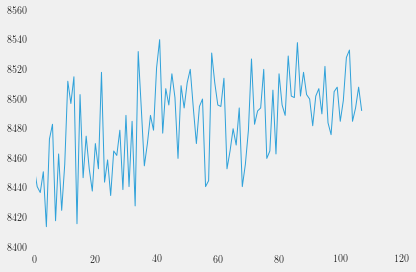

In [1124]:
plot(darks_flat_med_axis0)

In [1096]:
# darks_flat_sample_smooth = np.copy(darks_flat_sample) - darks_flat_med_axis0
quirks_store_smooth      = np.copy(quirks_store)      - darks_flat_med_axis0
rtn_syn_smooth           = np.copy(rtn_syn)           - darks_flat_med_axis0
darks_flat_sample_smooth = np.copy(darks_flat_sample) - darks_flat_med_axis0

NameError: name 'darks_flat_sample' is not defined

In [66]:
print(quirks_store_smooth.shape, rtn_syn_smooth.shape, darks_flat_sample_smooth.shape)

(5042, 108) (1000, 108) (4999, 108)


/Users/jonathanfraine/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


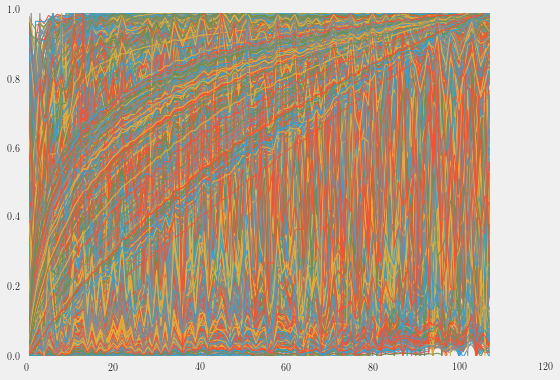

In [67]:
plot(((quirks_store_smooth.T - np.min(quirks_store_smooth,axis=1)) / (np.max(quirks_store_smooth,axis=1) - np.min(quirks_store_smooth,axis=1))));

/Users/jonathanfraine/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


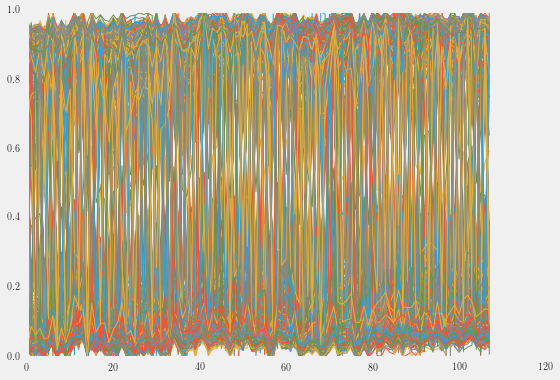

In [68]:
plot(((rtn_syn_smooth.T - np.min(rtn_syn_smooth,axis=1)) / (np.max(rtn_syn_smooth,axis=1) - np.min(rtn_syn_smooth,axis=1))));

/Users/jonathanfraine/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


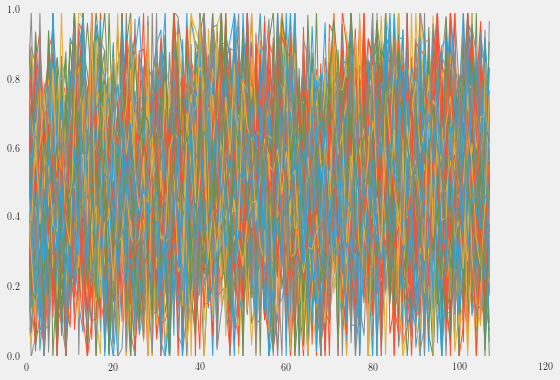

In [69]:
quirksNoisy = quirks_store_smooth[classes_store==1]
plot(((quirksNoisy.T - np.min(quirksNoisy,axis=1)) / (np.max(quirksNoisy,axis=1) - np.min(quirksNoisy,axis=1))));

/Users/jonathanfraine/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


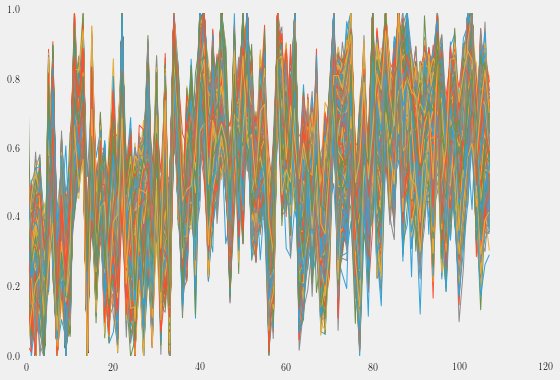

In [70]:
plot(((darks_flat_sample_smooth.T - np.min(darks_flat_sample_smooth,axis=1)) / (np.max(darks_flat_sample_smooth,axis=1) - np.min(darks_flat_sample_smooth,axis=1))));

Random Forest Classification
---

Load Sci-kit Learn Libraries

In [71]:
from sklearn.ensemble         import RandomForestClassifier
from sklearn.utils            import shuffle
from sklearn.cross_validation import train_test_split
from sklearn.externals        import joblib

In [80]:
classes_store[np.where(classes_store > 3)] += 1

In [1095]:
darks_classes     = np.zeros(darks_flat_sample_smooth.shape[0],dtype=int)
rtn_classes       = rtn_classes + 7
samples_train_set = vstack([quirks_store, rtn_syn, darks_flat_sample])
classes_train_set = vstack([quirkCheck[:,None], rtn_classes[:,None], darks_classes[:,None]])[:,0]

NameError: name 'darks_flat_sample_smooth' is not defined

In [104]:
samples_train_set.shape

(11041, 108)

In [105]:
samples_train_set_resort = shuffle(np.copy(samples_train_set), random_state=42)
classes_train_resort = shuffle(np.copy(classes_train_set), random_state=42)

Rescaled all samples from 0 to 1

In [106]:
samples_train_set_resort.shape

(11041, 108)

In [107]:
samples_train_set_resort_scaled = ((       samples_train_set_resort.T  - np.min(samples_train_set_resort,axis=1)) / \
                                   (np.max(samples_train_set_resort,axis=1) - np.min(samples_train_set_resort,axis=1))).T

In [108]:
samples_train_set_resort_scaled.shape

(11041, 108)

/Users/jonathanfraine/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


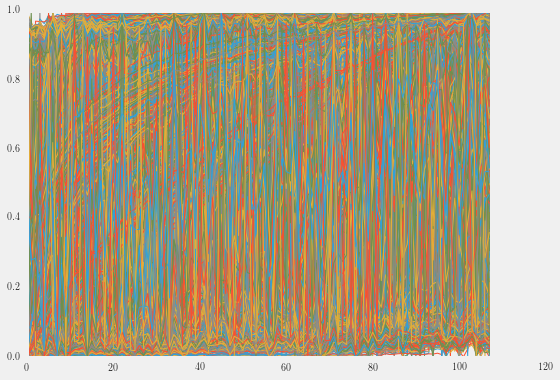

In [109]:
plot(samples_train_set_resort_scaled.T);

Establish Random Forest Classification
- 1000 trees
- OOB Score
- Multiprocessing

In [110]:
rfc = RandomForestClassifier(n_estimators=1000, oob_score=True, n_jobs=-1, random_state=42, verbose=True)

Split Samples into 75% Train and 25% Test

Shuffle Training Data Set

Train Classifier with `rfc.fit`

In [111]:
rfc.fit(samples_train_set_resort_scaled, classes_train_resort)

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   26.5s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=True, random_state=42, verbose=True,
            warm_start=False)

Score Classifier with Test Data Score

In [112]:
rfc.score(samples_train_set_resort_scaled, classes_train_resort)

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    1.5s finished


1.0

Score Classifier with Out-of-Bag Error

In [113]:
rfc.oob_score_

0.99266370799746395

Save Random Forest Classifier becuse 98% is AWESOME!

In [114]:
joblib.dump(rfc, 'trained_RF_Classifier/random_forest_classifier_trained_on_resorted_samples_train_set_RTN_CR_HP_Other_Norm.save')
joblib.dump(dict(samples=samples_train_set_resort_scaled.T, classes=classes_train_resort), 'trained_RF_Classifier/RTN_CR_HP_Other_Norm_resorted_samples_train_set.save')

['trained_RF_Classifier/RTN_CR_HP_Other_Norm_resorted_samples_train_set.save',
 'trained_RF_Classifier/RTN_CR_HP_Other_Norm_resorted_samples_train_set.save_01.npy',
 'trained_RF_Classifier/RTN_CR_HP_Other_Norm_resorted_samples_train_set.save_02.npy']

In [115]:
darks_reshaped.shape

(4194304, 108)

In [85]:
step     = 0
skipsize = 100
chunkNow = arange(step*darks_reshaped.shape[0]//skipsize,min((step+1)*darks_reshaped.shape[0]//skipsize, darks_reshaped.shape[0]))

In [86]:
darks_reshaped_chunk        = darks_reshaped[chunkNow]
darks_reshaped_chunk_smooth = darks_reshaped_chunk #/ darks_flat_med_axis0
darks_reshaped_chunk_scaled = ((darks_reshaped_chunk_smooth.T - np.min(darks_reshaped_chunk_smooth,axis=1)) / \
                              ((np.max(darks_reshaped_chunk_smooth,axis=1) - np.min(darks_reshaped_chunk_smooth,axis=1)))).T

In [89]:
samples_train_set_resort_scaled.shape, darks_reshaped_chunk_smooth.shape

((11041, 108), (41943, 108))

/Users/jonathanfraine/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


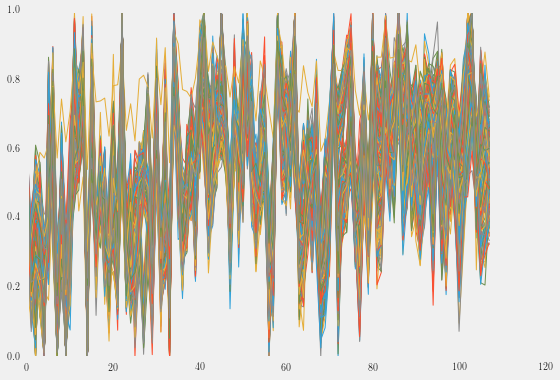

In [90]:
plot((darks_reshaped_chunk_scaled[::100]).T);

In [124]:
rfc_pred = np.zeros(darks_reshaped.shape[0])
rfc2_pred= np.zeros(darks_reshaped.shape[0])
step     = 0
skipsize = 50

gapSize  = rfc_pred.size//skipsize

start = time()
for step in range(skipsize):
    chunkNow = arange(step*gapSize,min((step+1)*gapSize, rfc_pred.size))
    print(chunkNow.min(), chunkNow.max(), end=" ")
    #
    # darks_reshaped_k_scaled = ((darks_reshaped[chunkNow].T - np.min(darks_reshaped[chunkNow],axis=1)) / \
    #                           ((np.max(darks_reshaped[chunkNow],axis=1) - np.min(darks_reshaped[chunkNow],axis=1)))).T
    # darks_reshaped_chunk        = darks_reshaped[chunkNow]
    # darks_reshaped_chunk_smooth = darks_reshaped_chunk #/ darks_flat_med_axis0
    darks_reshaped_chunk_scaled = ((darks_reshaped[chunkNow].T - np.min(darks_reshaped[chunkNow],axis=1)) / \
                                  ((np.max(darks_reshaped[chunkNow],axis=1) - np.min(darks_reshaped[chunkNow],axis=1)))).T
    #
    rfc_pred[chunkNow]  = rfc.predict(darks_reshaped_chunk_scaled)
    badPix              = rfc_pred != 0.0
    numBad              = badPix.sum()
    percentBad          = str(numBad / rfc_pred.size * 100)[:5] + '%'
    print(percentBad, rfc_pred[badPix][::numBad//10])

print('Operation Took ' + str(time() - start) + ' seconds')

0 83885 

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    3.8s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    7.0s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    8.6s finished


0.127661151783 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
83886 167771 

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    2.4s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    4.1s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    5.8s finished


0.147139154248 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
167772 251657 

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    2.5s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    4.6s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    6.3s finished


0.139764523298 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
251658 335543 

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    3.9s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    5.7s finished


0.118482360212 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
335544 419429 

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    2.4s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    3.9s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    5.8s finished


0.120233015582 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
419430 503315 

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    3.8s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    5.4s finished


0.148652004048 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
503316 587201 

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    2.3s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    3.7s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    5.4s finished


0.128036748973 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
587202 671087 

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    2.9s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    6.0s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    8.1s finished


0.119779067672 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
671088 754973 

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    2.4s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    4.3s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    5.8s finished


0.117268781496 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
754974 838859 

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    4.1s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    5.8s finished


0.126676426186 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
838860 922745 

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    2.3s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    4.0s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    5.7s finished


0.141618473638 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
922746 1006631 

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    3.6s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    5.2s finished


0.143349870477 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
1006632 1090517 

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    3.9s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    5.6s finished


0.133747030737 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
1090518 1174403 

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    2.4s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    4.0s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    5.7s finished


0.124269625559 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
1174404 1258289 

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    3.8s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    5.4s finished


0.139364647659 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
1258290 1342175 

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    3.8s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    5.3s finished


0.129777578955 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
1342176 1426061 

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    2.4s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    4.0s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    5.7s finished


0.145707146579 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
1426062 1509947 

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    4.7s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    6.3s finished


0.147392839425 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
1509948 1593833 

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    4.0s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    5.7s finished


0.142306058222 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
1593834 1677719 

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    3.7s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    5.4s finished


0.152834721276 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
1677720 1761605 

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    2.3s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    3.8s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    5.5s finished


0.163437378704 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
1761606 1845491 

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    2.3s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    4.0s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    5.7s finished


0.154429379145 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
1845492 1929377 

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    2.4s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    4.0s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    5.7s finished


0.131597225625 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
1929378 2013263 

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    3.7s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    5.4s finished


0.158441673477 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
2013264 2097149 

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    2.4s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    4.0s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    5.5s finished


0.152081499785 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  4.]
2097150 2181035 

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    3.8s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    5.5s finished


0.13127060619 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
2181036 2264921 

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    2.3s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    3.9s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    5.7s finished


0.127829232516 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
2264922 2348807 

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    2.3s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    3.9s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    5.6s finished


0.142766565418 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
2348808 2432693 

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    2.5s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    4.3s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    5.9s finished


0.162994171341 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
2432694 2516579 

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    4.8s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    6.4s finished


0.146796986299 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
2516580 2600465 

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    4.4s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    6.1s finished


0.141023251288 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
2600466 2684351 

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    2.3s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    4.1s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    5.7s finished


0.161991331139 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
2684352 2768237 

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    2.9s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    5.4s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    7.0s finished


0.139782770643 [ 0.  0.  0.  0.  0.  0.  0.  4.  0.  0.  0.]
2768238 2852123 

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    2.3s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    4.1s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    6.0s finished


0.133661672564 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
2852124 2936009 

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    2.3s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    4.0s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    5.6s finished


0.114442085087 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
2936010 3019895 

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    3.8s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    5.3s finished


0.128951022188 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
3019896 3103781 

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    3.8s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    5.6s finished


0.126053586089 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
3103782 3187667 

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    2.4s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    4.6s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    6.2s finished


0.126856290873 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
3187668 3271553 

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    4.9s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    6.5s finished


0.133226023196 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
3271554 3355439 

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    2.4s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    4.0s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    5.8s finished


0.1379644745 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
3355440 3439325 

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    2.3s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    3.9s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    5.6s finished


0.119468802603 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
3439326 3523211 

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    2.3s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    4.4s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    6.7s finished


0.124868230312 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  4.]
3523212 3607097 

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    3.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    5.5s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    6.8s finished


0.123338765717 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
3607098 3690983 

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    2.1s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    3.4s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    5.1s finished


0.116848393629 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
3690984 3774869 

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    3.4s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    4.9s finished


0.134950088656 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
3774870 3858755 

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    4.9s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    7.0s finished


0.132782304974 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
3858756 3942641 

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    5.5s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    7.3s finished


0.12567187197 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
3942642 4026527 

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    4.7s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    6.9s finished


0.127471580326 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
4026528 4110413 

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    4.7s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    6.6s finished


0.147772280624 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
4110414 4194299 

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    2.9s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    5.7s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    7.9s finished


0.130639250076 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Operation Took 557.1945140361786 seconds


In [131]:
print(str((rfc_pred != 0.0).sum() / rfc_pred.size * 100)[:5] + '%')

0.205%


In [132]:
for k in range(6):
    print(k,sum(rfc_pred == k))

0 4185679
1 1157
2 4445
3 619
4 1325
5 574


In [133]:
rfc_pred_train = rfc.predict(samples_train_set_resort_scaled)

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    1.0s finished


In [136]:
1-np.abs(rfc_pred_train - classes_train_resort).sum() / classes_train_resort.size, rfc.score(samples_train_set_resort_scaled, classes_train_resort)

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    1.3s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:    1.5s finished


(1.0, 1.0)

Could this be an RTN? 


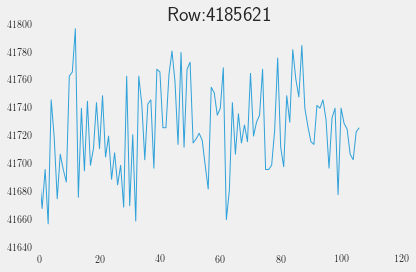

In [141]:
fig = figure()#figsize=(6,6))
ax  = fig.add_subplot(111)
# ax.plot([nan,nan])
class3Check = []
for iRTN, irow in enumerate(np.where(rfc_pred == 3)[0]):
    # ax.lines.pop()
    ax.clear()
    ax.plot(darks_reshaped[irow][1:]);
    ax.set_title('Row:' + str(irow) + ' iRTN:' + str(iRTN) + ' / ' + str(sum(rfc_pred == 3
                                                                            )))
    fig.canvas.draw()
    display.display(plt.gcf())
    display.clear_output(wait=True)
    class3Check.append(input('Could this be an RTN? '))

In [148]:
class3Check_array = np.zeros(len(class3Check), dtype=bool)
for k, c3cNow in enumerate(class3Check):
    if c3cNow.lower() in ['', 'y', 'd', 'yu']:
        class3Check_array[k] = True
    elif c3cNow.lower() in ['o']:
        class3Check_array[k-1] = True
    elif c3cNow.lower() in ['n']:
        class3Check_array[k] = False
    else:
        print(k, c3cNow)

In [155]:
class3Check_array.size, len(class3Check)

(619, 619)

/Users/jonathanfraine/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


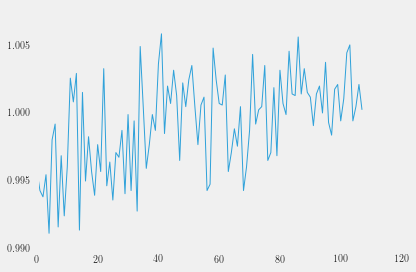

In [161]:
plot(darks_flat_med_axis0 / median(darks_flat_med_axis0))

In [163]:
darks_flat_med_axis0_norm = darks_flat_med_axis0[1:] / median(darks_flat_med_axis0[1:])

/Users/jonathanfraine/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype uint16 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/Users/jonathanfraine/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype uint16 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/Users/jonathanfraine/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


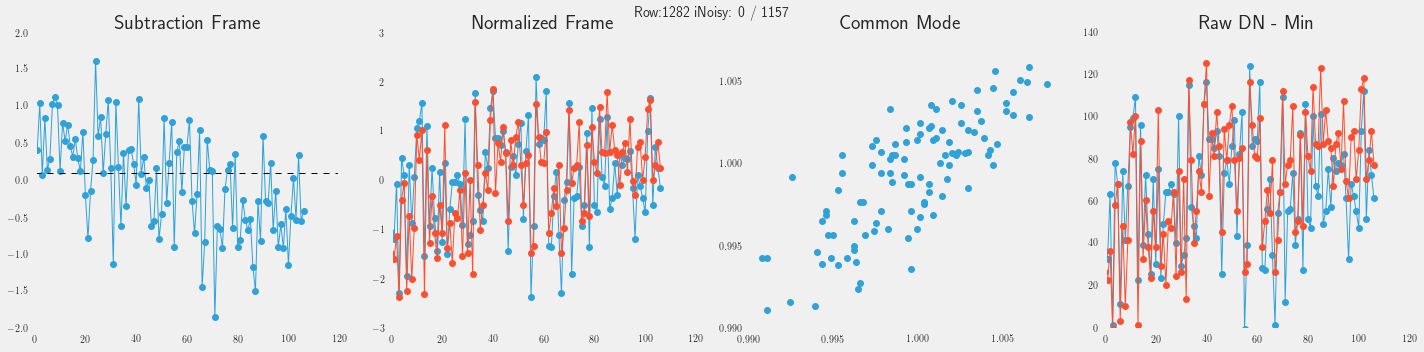

In [ ]:
fig = figure(figsize=(20,5))
ax1 = fig.add_subplot(141)
ax2 = fig.add_subplot(142)
ax3 = fig.add_subplot(143)
ax4 = fig.add_subplot(144)

# ax.plot([nan,nan])
class1Check = []
for iNoisy, irow in enumerate(np.where(rfc_pred == 1)[0]):
    ax1.clear()
    ax2.clear()
    ax3.clear()
    ax4.clear()
    # ax1.plot(darks_reshaped[irow][1:] / median(darks_reshaped[irow][1:]) - darks_flat_med_axis0_norm);
    
    # Plot Subtraction frame: (Darknow - min(Darknow)) - (DarkMed - min(DarkMed))
    # darkNowMinusMed = (darks_reshaped[irow][1:] - np.min(darks_reshaped[irow][1:])) - \
    #                   (darks_flat_med_axis0[1:] - np.min(darks_flat_med_axis0[1:]))
    
    darkNowMinusMed = pp.scale(darks_reshaped[irow][1:]) - pp.scale(darks_flat_med_axis0_norm)
    ax1.plot(darkNowMinusMed,'o-')
    ax1.axhline(median(darkNowMinusMed), linestyle='--', color='k')
    ax1.set_title('Subtraction Frame')
    # ax1.plot(darks_reshaped[irow][1:] / median(darks_reshaped[irow][1:]) / darks_flat_med_axis0_norm - 1);
    
    # Plot Normalized Frame: DarkNow vs DarMed
    ax2.plot(pp.scale(darks_reshaped[irow][1:]),'o-');
    ax2.plot(pp.scale(darks_flat_med_axis0_norm),'o-')
    ax2.set_title('Normalized Frame')
    
    # Plot Common Mode Correlation Frame
    ax3.plot(darks_reshaped[irow][1:] / median(darks_reshaped[irow][1:]), darks_flat_med_axis0_norm,'o')
    ax3.set_title('Common Mode')
    
    # Plot Raw DN minus Min Dark Ramp: DarkNow - min(DarkNow) vs DarkMed - min(DarkMed)
    ax4.plot(darks_reshaped[irow][1:] - np.min(darks_reshaped[irow][1:]),'o-')
    ax4.plot(darks_flat_med_axis0[1:] - np.min(darks_flat_med_axis0[1:]),'o-')
    ax4.set_title('Raw DN - Min')
    
    # ax.plot(darks_flat_med_axis0[1:] / median(darks_flat_med_axis0[1:]))
    #ax1.set_title('Row:' + str(irow) + ' iNoisy: ' + str(iNoisy) + ' / ' + str(sum(rfc_pred == 1)))
    fig.suptitle('Row:' + str(irow) + ' iNoisy: ' + str(iNoisy) + ' / ' + str(sum(rfc_pred == 1)))
    # ax1.set_ylim(ax2.get_ylim())
    fig.canvas.draw()
    display.display(plt.gcf())
    display.clear_output(wait=True)
    class1Check.append(input('Could this be an RTN? '))

In [ ]:
fig = figure()#figsize=(6,6))
ax  = fig.add_subplot(111)
# ax.plot([nan,nan])
rtn_synCheck = []
for iRTN, rtnNow in enumerate(rtn_syn):
    # ax.lines.pop()
    ax.clear()
    ax.plot(rtnNow);
    ax.set_title('iRTN:' + str(iRTN) + ' / ' + str(len(rtn_syn)))
    fig.canvas.draw()
    display.display(plt.gcf())
    display.clear_output(wait=True)
    #class3Check.append(input('Could this be an RTN? '))